# **Furniture Product Names**  extraction using Fine Tuned **Transformer Models**  

## Install and import requirements

In [ ]:
!apt update
!pip install selenium
!apt install chromium-chromedriver
!pip install seqeval
!pip install datasets
!pip install evaluate
!pip install sentence_transformers

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,648 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,451 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,278 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [33.7 kB]
Get:13 https://developer.download.nvidia.com/compute/cuda/repos

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException, WebDriverException
from google.colab import files
from datasets import Dataset
from evaluate import load
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import itertools
import copy
import pandas as pd
import numpy as np
import torch
import re
import shutil
import os
import glob

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Read the csv file with urls

In [ ]:
df = pd.read_csv('furniture stores pages.csv')
df.head()

,max(page)
0,https://www.factorybuys.com.au/products/euro-t...
1,https://dunlin.com.au/products/beadlight-cirrus
2,https://themodern.net.au/products/hamar-plant-...
3,https://furniturefetish.com.au/products/oslo-o...
4,https://hemisphereliving.com.au/products/


In [ ]:
urls = df['max(page)']
print("Total number of urls: ",len(urls))

print("url example: ",urls[10])

Total number of urls:  704
url example:  https://www.ourfurniturewarehouse.com.au/products/athens-3pce-lounge-includes-2x-armless-3-seater-and-corner-ottoman-in-grey-storm-fabric?_pos=1&_sid=9f9ca4320&_ss=r


## Define the necessary functions for extracting content from web pages

In [ ]:
def add_space_between_characters(text):
    # Add space between:
    # 1. Lowercase letter, "...", ")", "," and an uppercase letter
    modified_text = re.sub(r'([a-z]|\.{3}|\)|,)([A-Z])', r'\1 \2', text)
    # 2. Lowercase letter and a number
    modified_text = re.sub(r'([a-wy-z]|\.{3}|\))([0-9])', r'\1 \2', modified_text)

    return modified_text

In [ ]:
dr = None

In [ ]:
def initialize_driver():
  # Set up Chrome WebDriver
  global dr
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  dr = webdriver.Chrome(options=options)



In [ ]:
initialize_driver()

In [ ]:
def extract_urls(inf,sup,urls):
  global dr
  # Extract content from given urls using Selenium and BeautifulSoup
  timeout_seconds = 25
  ct = inf
  reached, not_responding, not_reached = [], [], []

  if not os.path.exists("urls"):
        os.makedirs("urls")

  for index, url in enumerate(urls[inf:sup]):
      try:
          # Set a timeout for the URL load
          dr.set_page_load_timeout(timeout_seconds)

          # Try to get the page source
          dr.get(url)
          page_source = dr.page_source

          # Parse the page source with BeautifulSoup
          soup = BeautifulSoup(page_source, 'html.parser')
          page_source = soup.get_text()

          # Remove leading/trailing spaces and empty lines
          cleaned_text = [line.strip() for line in page_source.splitlines() if line.strip()]

          # Replace more than two consecutive spaces with exactly two spaces
          cleaned_text = [re.sub(r'\s{3,}', '  ', line) for line in cleaned_text]

          # Remove lines containing specific characters or patterns
          cleaned_text = [line for line in cleaned_text if not any(x in line for x in ["{", "}", "[", "]", "----"])]

          #Add space between certain characters
          cleaned_text = [add_space_between_characters(line) for line in cleaned_text]

          # Join cleaned lines back into a single string
          cleaned_page_source = '\n'.join(cleaned_text)

          # Create a file to store the cleaned content
          with open(f"urls/url_content_{index+ct}.txt", "w", encoding="utf-8") as file:
              file.write(cleaned_page_source)

          reached.append(index+ct)

      except TimeoutException:
          # Handle URLs that are not responding within the timeout
          print(f"URL not responding: {url}")

          # Write the status to a .txt file
          with open(f"urls/url_content_{index+ct}.txt", "w", encoding="utf-8") as file:
              file.write("URL not responding")

          not_responding.append(index+ct)

          # Reinitialize driver
          dr.quit()
          initialize_driver()

      except WebDriverException:
          # Handle cases where the website can't be reached (net::ERR_NAME_NOT_RESOLVED, etc.)
          print(f"URL cannot be reached: {url}")

          # Write the status to a .txt file
          with open(f"urls/url_content_{index+ct}.txt", "w", encoding="utf-8") as file:
              file.write("URL cannot be reached")

          not_reached.append(index+ct)

  return reached, not_responding, not_reached


In [ ]:
# Test the function
lst1,lst2,lst3 = extract_urls(0,5,urls)


In [ ]:
# Zip the url content
!zip -r /content/texts.zip /content/urls

### Define the required functions in order to process the **Dataset**  

In [ ]:
def tag_entities(txt_file, ann_file):
  # Prase the content from web pages and the corresponding annotation files for PRODUCT entities
  # and tag every word using BIO tagging format

    # Read the sentences from the text file
    with open(txt_file, 'r', encoding='utf-8') as f:
        sentences = f.readlines()

    # Read the annotations from the ann file
    with open(ann_file, 'r', encoding='utf-8') as f:
        annotations = f.readlines()

    # Initialize a dictionary to store the entities with their positions
    entity_dict = {}

    # Initialize results list to hold sentences and tags
    results = []

    # Check if there are no tags found
    if annotations[0]  == '.':

      # Check if the first annotation indicates no tags found
      for sentence in sentences:
        # Process each sentence when there are no tag
        sentence = sentence.strip()
        word_list = sentence.split()
        n = len(word_list)
        tags = ['O'] * n

        # Remove words longer than 35 characters
        index = 0
        while index < n:
          while index < n and len(word_list[index]) > 35:
            word_list.pop(index)
            tags.pop(index)
            n-=1
          index +=1

        # Append to result
        if len(word_list) > 0:
          results.append((word_list+['ENDLINE'],tags+['O']))

      # Create a DataFrame to store the results
      df = pd.DataFrame(results, columns=['Sentence', 'Tags'])
      return df

    # Process annotations
    for annotation in annotations:
        # Parse the annotation file
        parts = annotation.strip().split()
        start = int(parts[2])
        end = int(parts[3])
        entity_text = " ".join(parts[4:])
        entity_dict[(start, end)] = entity_text

    # Prepare a list to hold results
    count = 0 # Store the overall character count
    # Process each sentence for tagging
    for sentence in sentences:
        sentence = sentence.strip()
        word_list = sentence.split()
        n = len(word_list)
        tags = ['O'] * n  # Initialize tags with 'O'

        # Tag entities based on their start and end positions
        for (start, end), entity_text in entity_dict.items():

            # Check if the entity falls within the current sentence
            if count <= start and end <= count+len(sentence):
                start_index = start - count
                end_index = end - count

                # Calculate the number of words before and after the entity
                num_words_before = len(sentence[0:start_index].split())
                num_words_after = len(sentence[end_index:].split())
                num_words_total = len(word_list)
                num_tag_words = num_words_total - num_words_before - num_words_after

                first_word = True # Flag for the first word of the entity
                for i in range(num_words_before,num_words_before+num_tag_words):
                  if first_word == True:
                    # Tag the first word as the beginning of a product
                    tags[i] = 'B-PROD'
                    first_word = False
                  else:
                    # Tag subsequent words as inside the product entity
                    tags[i] = 'I-PROD'

        # Update the overall character count
        count +=len(sentence)+1  #Add sentence length and newline

        # Remove words longer than 35 characters
        index = 0
        while index < n:
          while index < n and len(word_list[index]) > 35:
            word_list.pop(index)
            tags.pop(index)
            n-=1

          index +=1

        # Append to result
        if len(word_list) > 0:
          results.append((word_list+['ENDLINE'],tags+['O']))

    # Create a DataFrame
    df = pd.DataFrame(results, columns=['Sentence', 'Tags'])

    return df

In [ ]:
def concatenate_sentences(df,limit):
  # Concatenate sentences such that the number of words should not cross the limit

  # Initialize lists
  result = []
  current_sentence, current_tags = [], []

  # Iterate over each sentence
  for sentence, tags in zip(df['Sentence'], df['Tags']):
      # Check if the length of the current sentence plus the new sentence is within the limit
      if len(current_sentence) + len(sentence) <= limit:
          # If within limit, append the sentence and its tags to the current lists
          for i in range(len(sentence)):
            current_sentence.append(sentence[i])
            current_tags.append(tags[i])
      else:
          # If exceeding the limit, append the current concatenated sentence and tags to the result
          result.append((current_sentence, current_tags))

          current_sentence, current_tags = [], []
          # Append the new sentence and its tags
          for i in range(len(sentence)):
            current_sentence.append(sentence[i])
            current_tags.append(tags[i])

  # After looping, check if there are any remaining words/tags in current_sentence
  if current_sentence:
      result.append((current_sentence, current_tags))

  # Create and return a DataFrame from the results
  return  pd.DataFrame(result, columns=['Sentence', 'Tags'])



In [ ]:
def divide_sentences(df,limit):
  # If a sentence has more words than limit, divide sentence without separating PRODUCT entities

  # Initialize lists
  result = []
  current_sentence, current_tags = [], []

  # Iterate over each sentence and its tags in the DataFrame
  for sentence, tags in zip(df['Sentence'], df['Tags']):

    # If the sentence length is within the limit, no need to divide
    if len(sentence) <= limit:
      result.append((sentence,tags))
    else:
      # For longer sentences that exceed the limit, we need to divide them
      left, right = 0,0 # Initialize window pointers
      current_sentence, current_tags = [], []

      while right < len(sentence):
        # Expand the current window while it is within the limit
        while right - left + 1 < limit  and right < len(sentence):
          current_sentence.append(sentence[right])
          current_tags.append(tags[right])
          right +=1

        # If we've reached the end of the sentence, continue to the next iteration/sentence
        if right == len(sentence):
          continue

        #right - left == limit
        # Check if the current tag is part of an entity and if splitting might cut through it
        if (tags[right] == 'B-PROD' or tags[right] == 'I-PROD') and tags[right+1] == 'I-PROD':
          # Add the current word/tag to the sentence if it's part of an entity
          current_sentence.append(sentence[right])
          current_tags.append(tags[right])

          # Special case where a product entity starts and continues across sentences
          if tags[right] == 'B-PROD' and tags[right+1] == 'I-PROD':
            current_sentence.pop() # Remove the 'B-PROD' entity from the sentence
            current_tags.pop()
            left = right

          # Special case where we're in the middle of an 'I-PROD' sequence
          elif tags[right] == 'I-PROD':
            # Remove all 'I-PROD' tags from the sentence to avoid cutting through the entity
            while tags[right] == 'I-PROD':
              current_sentence.pop()
              current_tags.pop()
              right -=1

            #Pop B-PROD tag
            current_sentence.pop()
            current_tags.pop()
            left = right

           # Append the current sentence and its tags to the result
          result.append((current_sentence, current_tags))
          current_sentence, current_tags = [], []
        else:
          # If no special case, continue normally by appending the word/tag
          current_sentence.append(sentence[right])
          current_tags.append(tags[right])

          # Append the sentence and tags to the result
          result.append((current_sentence, current_tags))
          current_sentence, current_tags = [], []
          # Move pointers
          right+=1
          left = right

      # If there's any remaining sentence after the loop, append it to the result
      if current_sentence:

        result.append((current_sentence, current_tags))
        current_sentence, current_tags = [], []


  return pd.DataFrame(result, columns=['Sentence', 'Tags'])


In [ ]:
def check_tagging(data_dir,ann_dir):
# Function to check if all annotations from the annotation files correclty
# match the tagged words returned by tag_entities function
  data_dir = data_dir
  ann_dir = ann_dir

  # Get all .txt and .ann files in the directories
  txt_files = sorted(glob.glob(os.path.join(data_dir, 'url_content_*.txt')))
  ann_files = sorted(glob.glob(os.path.join(ann_dir, 'url_content_*.ann')))

  # Initialize lists to store any mismatches
  all_found_products = []
  ann_super = []
  # Process each corresponding .txt and .ann file
  for txt_file, ann_file in zip(txt_files, ann_files):
      # Get the number of txt and ann file
      txt_number = os.path.splitext(os.path.basename(txt_file))[0].split('_')[-1]
      ann_number = os.path.splitext(os.path.basename(ann_file))[0].split('_')[-1]

      if txt_number == ann_number:
          # Get tags
          table = tag_entities(txt_file, ann_file)

          # Get annotations from every ann file and store them in ann_super
          with open(ann_file, 'r', encoding='utf-8') as f:
            annotations = f.readlines()
          ann_list = []

          if annotations[0] !='.':
            for annotation in annotations:
              parts = annotation.strip().split()
              start = int(parts[2])
              end = int(parts[3])
              entity_text = parts[4:]
              ann_list.append(entity_text)

          ann_super.append(ann_list)

          # Initialize a list to store the products for the current table
          table_products = []
          for index, row in table.iterrows():
              sentence = row['Sentence']
              tags = row['Tags']
              current_product = []
              found = []

              # Loop through the words and their corresponding tags
              for word, tag in zip(sentence, tags):
                  if tag == 'B-PROD':  # Beginning of a product entity
                      if current_product: # Append the last product entity
                          found.append(current_product)
                      current_product = [word]
                  elif tag == 'I-PROD' and current_product:  # Inside a product entity
                      current_product.append(word)
                  else:
                      if current_product: # End of a product entity
                          found.append(current_product)
                          current_product = []

              # If there's a product entity left at the end of the sentence, store it
              if current_product:
                  found.append(current_product)

              if found:
              # Append found products for this sentence to the table products list
                table_products.append(found)

          # Add the products found in this table to the overall list
          all_found_products.append(table_products)

  # all_found_products now contains lists of product entities from all tables

  mismatch = False
  for i in range(len(all_found_products)):
    click = []
    for sent in all_found_products[i]:
      for elem in sent:
        click.append(elem)
    if sorted(click) != sorted(ann_super[i]):
      mismatch = True
      print('Mismatch at file no ',i)
      print(sorted(click))
      print(sorted(ann_super[i]))
      print("-------")

  if mismatch == False:
    print("Ok")


In [ ]:
check_tagging('train_data/','train_ann/')

Ok


In [ ]:
check_tagging('test_data/','test_ann/')

Ok


In [ ]:
def process_dataset(txt_dir,ann_dir,limit):
  # Get paths
  _txt_dir = txt_dir
  _ann_dir = ann_dir

  # Get all .txt and .ann files in the directories
  txt_files = sorted(glob.glob(os.path.join(_txt_dir, 'url_content_*.txt')))
  ann_files = sorted(glob.glob(os.path.join(_ann_dir, 'url_content_*.ann')))


  # Initialize a list to store DataFrames
  dataframes = []

  # Process each corresponding .txt and .ann file
  for txt_file, ann_file in zip(txt_files, ann_files):
      # Extract the common number 'n' from the file names to ensure they match
      txt_number = os.path.splitext(os.path.basename(txt_file))[0].split('_')[-1]
      ann_number = os.path.splitext(os.path.basename(ann_file))[0].split('_')[-1]

      if txt_number == ann_number:
          # Call the functions tagging entities and processing sentences
          #from the .txt file and its .ann file
          table = tag_entities(txt_file, ann_file)
          table = divide_sentences(table,limit)
          table = concatenate_sentences(table,limit)
          dataframes.append(table)

  # Concatenate all DataFrames into one big DataFrame
  return pd.concat(dataframes, ignore_index=True)


In [ ]:
def count_products(df):
  # Count the number of PRODUCT entities in the data frame
  count = 0
  for index, row in df.iterrows():
    tags = row['Tags']
    for tag in tags:
      if tag == 'B-PROD':
        count+=1

  return count

### Parse the dataset from files and process it

In [ ]:
train_df = process_dataset('train_data/','train_ann/',64)
test_df = process_dataset('test_data/','test_ann/',64)

In [ ]:
# Count the number of products in train and test set
print("Number of products in the train set: ",count_products(train_df))
print("Number or products in the test set: ",count_products(test_df))

Number of products in the train set:  2692
Number or products in the test set:  675


## Initialize **DistilBERT** and **DistilRoBERTa** for the **NER** task


In [ ]:
label_list = ['O','B-PROD','I-PROD']
label_encoding_dict = {'O': 0, 'B-PROD':1, 'I-PROD':2}

task = "ner"
model_checkpoint = "distilbert-base-uncased"
model_checkpoint_2 = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer_roberta = AutoTokenizer.from_pretrained(model_checkpoint_2,add_prefix_space = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Process and tokenize the above dataset to fit the model input

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [ ]:
# Check the Dataset format
# Oberve that training set has 3860 training examples and test set 836
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['Sentence', 'Tags'],
    num_rows: 3860
})
Dataset({
    features: ['Sentence', 'Tags'],
    num_rows: 836
})


In [ ]:
# Print some examples
id = 0
print(train_dataset['Sentence'][id])
print(train_dataset['Tags'][id])

['Factory', 'Buys', '32cm', 'Euro', 'Top', 'Mattress', '-', 'King', 'ENDLINE', 'Skip', 'to', 'content', 'ENDLINE', 'FAST', 'SHIPPING', 'AUSTRALIA', 'WIDE!', 'ENDLINE', 'FREE', 'SHIPPING', 'ON', 'MATTRESSES*', 'ENDLINE', 'BED', 'FRAMES', 'FROM', '$96!', 'ENDLINE', 'FAST', 'SHIPPING', 'AUSTRALIA', 'WIDE!', 'ENDLINE', 'FREE', 'SHIPPING', 'ON', 'MATTRESSES*', 'ENDLINE', 'BED', 'FRAMES', 'FROM', '$96!', 'ENDLINE', 'FAST', 'SHIPPING', 'AUSTRALIA', 'WIDE!', 'ENDLINE', 'Home', 'Furniture', 'ENDLINE', 'Home', 'Furniture', 'ENDLINE', 'Bedroom', 'ENDLINE', 'Bedroom', 'ENDLINE', 'Mattresses', 'ENDLINE', 'Bed', 'Frames', 'ENDLINE']
['B-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
id_test = 30
print(test_dataset['Sentence'][id_test])
print(test_dataset['Tags'][id_test])

['Reviews', 'ENDLINE', "FAQ's", 'ENDLINE', 'Damage', 'Policy', 'ENDLINE', 'One', 'Year', 'Warranty', 'ENDLINE', 'Our', 'Story', 'ENDLINE', 'Terms', '&', 'Conditions', 'ENDLINE', 'Shipping', '&', 'Returns', 'ENDLINE', 'Returns', '&', 'Refund', 'Policy', 'ENDLINE', 'Contact', 'Us', 'ENDLINE', 'Our', 'Customers', 'ENDLINE', 'Request', 'Customization', 'ENDLINE', 'Sign', 'in', 'ENDLINE', 'Register', 'ENDLINE', 'Compare', 'ENDLINE', '0', 'ENDLINE', 'Home', 'ENDLINE', 'Dining', 'Room', 'ENDLINE', 'Bar', 'Tables', 'ENDLINE', 'Tulip', 'Fiberglass', 'Bar', 'Table,', '32"', 'Round', 'ENDLINE', 'Tulip', 'Bar', 'Table', 'ENDLINE']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'I-PROD', 'O', 'B-PROD', 'I-PROD', 'I-PROD', 'O']


In [ ]:
def tokenize_and_align_labels(examples,tokenizer):
  # Function that assigns corresponding labels
  # and the same label to the subtokens of a token
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["Sentence"]), truncation=True, is_split_into_words=True,padding = True)

    labels = []
    for i, label in enumerate(examples['Tags']):
        # Get word_ids (0,1,2,...)
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Check if the current word index is a special token ([CLS], [SEP],[PAD])
            if word_idx is None:
                label_ids.append(-100)

            elif label[word_idx] == '0':
                label_ids.append(0)
            # If it is a different word, assign the corresponding label ID from the label encoding dictionary
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            # If the current word index is the same as the previous word index (We have a subtoken a subtoken)
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# BERT tokenizer
train_tokenized_datasets = train_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer), batched=True)
test_tokenized_datasets = test_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer), batched=True)

Map:   0%|          | 0/3860 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

In [ ]:
# RoBERTa tokenizer
train_tokenized_datasets_roberta = train_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer_roberta), batched=True)
test_tokenized_datasets_roberta = test_dataset.map(lambda examples: tokenize_and_align_labels(examples, tokenizer_roberta), batched=True)

Map:   0%|          | 0/3860 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

In [ ]:
# Check the tokenized format
print(train_tokenized_datasets)
print(test_tokenized_datasets)

Dataset({
    features: ['Sentence', 'Tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3860
})
Dataset({
    features: ['Sentence', 'Tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 836
})


In [ ]:
print(train_tokenized_datasets_roberta)

Dataset({
    features: ['Sentence', 'Tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3860
})


In [ ]:
# Print an example
id = 0
print("Labels: ",train_tokenized_datasets[id]['labels'])
print("Words: ",train_tokenized_datasets[id]['Sentence'])
print("Input_ids: ",train_tokenized_datasets[id]['input_ids'])
print("Corresponding tokens of input_ids: ",tokenizer.batch_decode(train_tokenized_datasets['input_ids'][id],skip_special_token= True))
print("Attention mask: ",train_tokenized_datasets[id]['attention_mask'])

Labels:  [-100, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -10

In [ ]:
# Print an example for RoBERTa tokenizer
id = 0
print("Labels: ",train_tokenized_datasets_roberta[id]['labels'])
print("Words: ",train_tokenized_datasets_roberta[id]['Sentence'])
print("Input_ids: ",train_tokenized_datasets_roberta[id]['input_ids'])
print("Corresponding tokens of input_ids: ",tokenizer_roberta.batch_decode(train_tokenized_datasets_roberta['input_ids'][id],skip_special_token= True))
print("Attention mask: ",train_tokenized_datasets_roberta[id]['attention_mask'])

Labels:  [-100, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 

## Define the training arguments and the evaluation metrics

In [ ]:
from transformers import TrainerCallback

class SaveMetricsCallback(TrainerCallback):
    def __init__(self, file_name):
        self.file_name = file_name

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # This function is called after each evaluation (which happens at the end of each epoch)
        with open(self.file_name, "a") as f:
            f.write(f"Epoch {state.epoch}:\n")
            for key, value in metrics.items():
                f.write(f"{key}: {value}\n")
            f.write("\n")  # For spacing between epochs

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
model_roberta = AutoModelForTokenClassification.from_pretrained(model_checkpoint_2, num_labels=len(label_list))
batch_size = 16

args = TrainingArguments(
    "test-ner",
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    lr_scheduler_type="cosine_with_restarts",
    warmup_steps=160,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=7,
    weight_decay=1e-5,
    load_best_model_at_end= True,
    metric_for_best_model="eval_loss",
    greater_is_better= False
)

# Data_collator for preprocessing batches of data before feeding them into the model
data_collator = DataCollatorForTokenClassification(tokenizer)
data_collator_roberta = DataCollatorForTokenClassification(tokenizer_roberta)

metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}


trainer = Trainer(
    model = model,
    args = args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback(file_name = "metrics_bert_prod-ner.txt")]

)

# Write a trainer for RoBERTa
trainer_roberta = Trainer(
    model = model_roberta,
    args = args,
    train_dataset=train_tokenized_datasets_roberta,
    eval_dataset=test_tokenized_datasets_roberta,
    data_collator=data_collator_roberta,
    tokenizer=tokenizer_roberta,
    compute_metrics=compute_metrics,
    callbacks=[SaveMetricsCallback(file_name = "metrics_roberta_prod-ner.txt")]

)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


### Train, evaluate and save the model

In [ ]:
trainer.train()
trainer.evaluate()
trainer.save_model('bert_prod-ner.model')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.050560,0.696517,0.602799,0.646278,0.984263
2,No log,0.049119,0.806775,0.692142,0.745075,0.988115
3,0.083500,0.042362,0.770065,0.764263,0.767153,0.989445
4,0.083500,0.051543,0.748634,0.737352,0.742950,0.988376
5,0.008200,0.060453,0.782871,0.698601,0.738339,0.987745
6,0.008200,0.061910,0.778436,0.707212,0.741117,0.988006
7,0.002000,0.062361,0.788849,0.715823,0.750564,0.988198


In [ ]:
trainer_roberta.train()
trainer_roberta.evaluate()
trainer_roberta.save_model('roberta_prod-ner.model')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.055436,0.717718,0.637900,0.675459,0.983861
2,No log,0.048354,0.823887,0.724199,0.770833,0.988528
3,0.081700,0.040675,0.840816,0.733096,0.783270,0.988146
4,0.081700,0.040416,0.806393,0.785587,0.795854,0.988370
5,0.013600,0.047068,0.852284,0.780249,0.814677,0.990084
6,0.013600,0.055887,0.841633,0.751779,0.794173,0.989293
7,0.003400,0.057334,0.846154,0.753559,0.797176,0.989306


### Plot results

In [ ]:
### Print metrics
import matplotlib.pyplot as plt

def parse_evaluation_data(file_path):
    # Initialize lists to hold the values for each metric
    epochs = []
    eval_loss = []
    eval_precision = []
    eval_recall = []
    eval_f1 = []

    # Regex patterns to extract the values
    epoch_pattern = r'epoch:\s+(\d+\.?\d*)'
    loss_pattern = r'eval_loss:\s+([0-9.]+)'
    precision_pattern = r'eval_precision:\s+([0-9.]+)'
    recall_pattern = r'eval_recall:\s+([0-9.]+)'
    f1_pattern = r'eval_f1:\s+([0-9.]+)'

    # Read the file and extract metrics
    with open(file_path, 'r') as file:
        content = file.read()

        # Find all the epochs and corresponding metrics
        epochs = re.findall(epoch_pattern, content)
        eval_loss = re.findall(loss_pattern, content)
        eval_precision = re.findall(precision_pattern, content)
        eval_recall = re.findall(recall_pattern, content)
        eval_f1 = re.findall(f1_pattern, content)

    # Convert the extracted data to floats
    epochs = [float(epoch) for epoch in epochs]
    eval_loss = [float(loss) for loss in eval_loss]
    eval_precision = [float(precision) for precision in eval_precision]
    eval_recall = [float(recall) for recall in eval_recall]
    eval_f1 = [float(f1) for f1 in eval_f1]

    return epochs, eval_loss, eval_precision, eval_recall, eval_f1

def plot_metrics(epochs, eval_loss, eval_precision, eval_recall, eval_f1, title):
    # Create subplots
    plt.figure(figsize=(10, 8))

    # Set the overall title for the plot
    plt.suptitle(title, fontsize=16)

    # Plot Validation Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, eval_loss, marker='o', color='b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.grid(True)

    # Plot Precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, eval_precision, marker='o', color='g', label='Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision')
    plt.grid(True)

    # Plot Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, eval_recall, marker='o', color='r', label='Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall')
    plt.grid(True)

    # Plot F1 Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, eval_f1, marker='o', color='purple', label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.grid(True)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the title
    plt.show()

# Function to read the file and generate the plots
def process_and_plot(file_path, plot_title):
    epochs, eval_loss, eval_precision, eval_recall, eval_f1 = parse_evaluation_data(file_path)
    plot_metrics(epochs, eval_loss, eval_precision, eval_recall, eval_f1, plot_title)




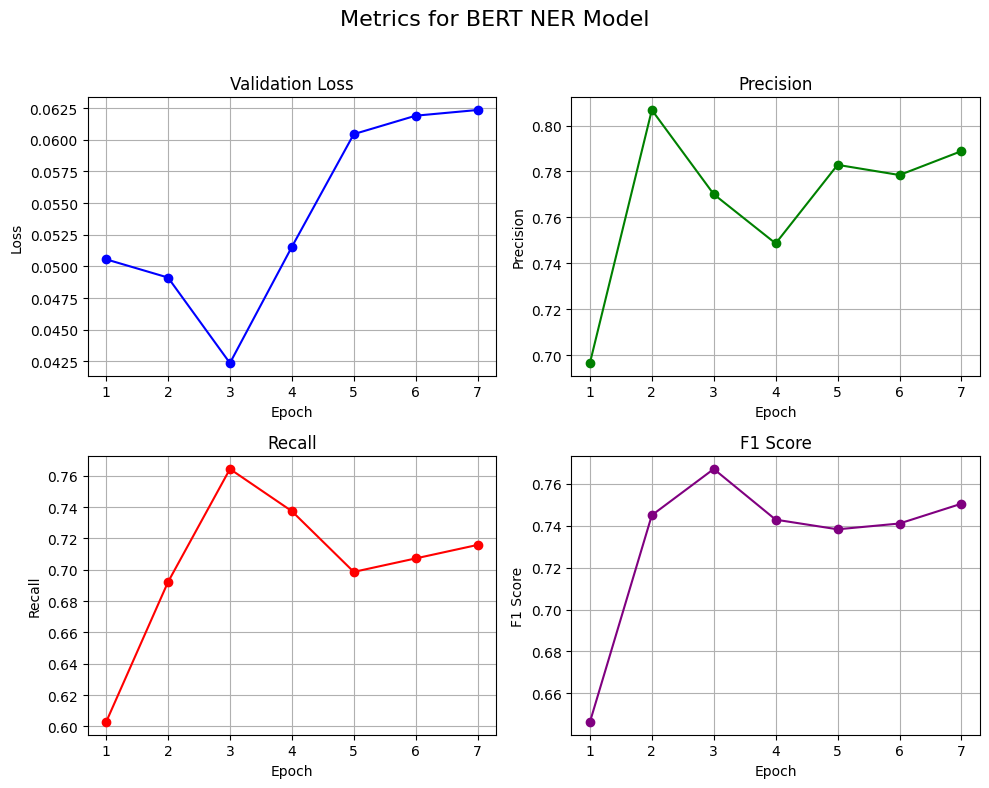

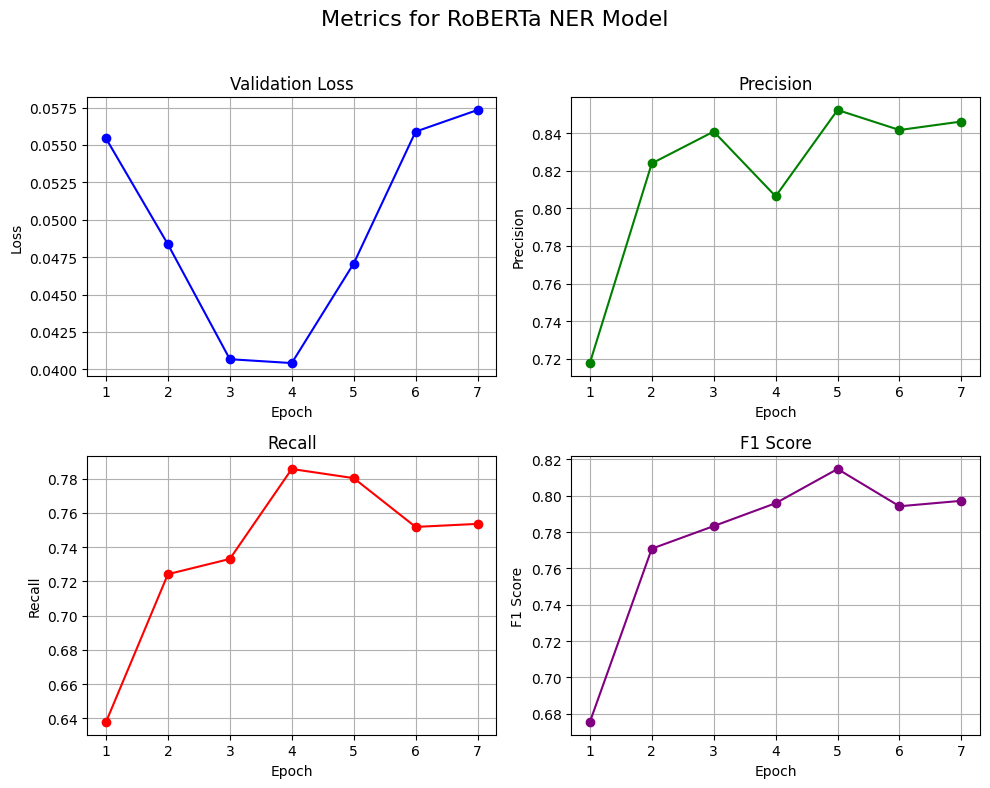

In [ ]:
file_path = 'metrics_bert_prod-ner.txt'
plot_title = 'Metrics for BERT NER Model'
process_and_plot(file_path, plot_title)

file_path = 'metrics_roberta_prod-ner.txt'
plot_title = 'Metrics for RoBERTa NER Model'
process_and_plot(file_path, plot_title)

### Zip and download the model

In [ ]:
!zip -r /content/roberta_prod-ner.zip /content/roberta_prod-ner.model

  adding: content/roberta_prod-ner.model/ (stored 0%)
  adding: content/roberta_prod-ner.model/special_tokens_map.json (deflated 52%)
  adding: content/roberta_prod-ner.model/config.json (deflated 51%)
  adding: content/roberta_prod-ner.model/model.safetensors (deflated 7%)
  adding: content/roberta_prod-ner.model/merges.txt (deflated 53%)
  adding: content/roberta_prod-ner.model/tokenizer.json (deflated 72%)
  adding: content/roberta_prod-ner.model/tokenizer_config.json (deflated 76%)
  adding: content/roberta_prod-ner.model/training_args.bin (deflated 51%)
  adding: content/roberta_prod-ner.model/vocab.json (deflated 59%)


In [ ]:
from google.colab import files
files.download('roberta_prod-ner.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Evaluate the chosen version of your fine tuned model after uploading it in this notebook

In [ ]:
!unzip /content/bert_prod-ner.zip

In [ ]:
!unzip /content/roberta_prod-ner.zip

Archive:  /content/roberta_prod-ner.zip
   creating: content/roberta_prod-ner.model/
  inflating: content/roberta_prod-ner.model/special_tokens_map.json  
  inflating: content/roberta_prod-ner.model/config.json  
  inflating: content/roberta_prod-ner.model/model.safetensors  
  inflating: content/roberta_prod-ner.model/merges.txt  
  inflating: content/roberta_prod-ner.model/tokenizer.json  
  inflating: content/roberta_prod-ner.model/tokenizer_config.json  
  inflating: content/roberta_prod-ner.model/training_args.bin  
  inflating: content/roberta_prod-ner.model/vocab.json  


In [ ]:
### Eval if necessary after loading pretrained
label_list = ['O','B-PROD','I-PROD']
label_encoding_dict = {'O': 0, 'B-PROD':1, 'I-PROD':2}
batch_size = 16
path_to_model = './content/roberta_prod-ner.model/'


test_df = process_dataset('test_data/','test_ann/',64)
test_dataset = Dataset.from_pandas(test_df)
if path_to_model == './content/roberta_prod-ner.model/':
  tokenizer = AutoTokenizer.from_pretrained(path_to_model,add_prefix_space = True)
else:
  #BERT tokenizer
  tokenizer = AutoTokenizer.from_pretrained(path_to_model)

test_tokenized_datasets = test_dataset.map(lambda examples: tokenize_and_align_labels(examples,tokenizer), batched=True)
model = AutoModelForTokenClassification.from_pretrained(path_to_model)


eval_args = TrainingArguments(
    "test-test",
    evaluation_strategy = "epoch",
    per_device_eval_batch_size=batch_size

)

# Data_collator for preprocessing batches of data before feeding them into the model
data_collator = DataCollatorForTokenClassification(tokenizer)


metric = load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }


eval_dataset = test_tokenized_datasets


trainer = Trainer(
    model=model,
    args=eval_args,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Evaluate the model on the test set
eval_result = trainer.evaluate(eval_dataset=eval_dataset)

print("Evaluation results:", eval_result)

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Evaluation results: {'eval_loss': 0.040416471660137177, 'eval_model_preparation_time': 0.0023, 'eval_precision': 0.806392694063927, 'eval_recall': 0.7855871886120996, 'eval_f1': 0.7958539882830103, 'eval_accuracy': 0.988370099816717, 'eval_runtime': 273.5816, 'eval_samples_per_second': 3.056, 'eval_steps_per_second': 0.194}


### Define the functions necessary for making predictions


In [ ]:
def tag_entities_test(txt_file):
    # Drop the BIO tagging format and create a similar DataFrame

    # Read the sentences from the text file
    with open(txt_file, 'r', encoding='utf-8') as f:
        sentences = f.readlines()

    results = []
    for sentence in sentences:

      sentence = sentence.strip()
      words = sentence.split()
      tags = ['O'] * len(words)
      word_list = sentence.split()
      results.append((word_list+['ENDLINE'],tags+['O']))



        #results.append((sentence.split(),tags))
    df = pd.DataFrame(results, columns=['Sentence', 'Tags'])
    return df

In [ ]:
def divide_sentences_test(df,limit):
  # Divide sentences if the limit is exceeded

  result = []
  current_sentence, current_tags = [], []
  for sentence, tags in zip(df['Sentence'], df['Tags']):
    if len(sentence) <= limit:
      result.append((sentence,tags))
    else:
      left, right = 0,0
      current_sentence, current_tags = [], []
      while right < len(sentence):
        while right - left + 1 < limit  and right < len(sentence):
          current_sentence.append(sentence[right])
          current_tags.append(tags[right])
          right +=1
        if right == len(sentence):
          continue

        current_sentence.append(sentence[right])
        current_tags.append(tags[right])
        result.append((current_sentence, current_tags))
        current_sentence, current_tags = [], []
        right+=1
        left = right

      if current_sentence:
        result.append((current_sentence, current_tags))
        current_sentence, current_tags = [], []

  return pd.DataFrame(result, columns=['Sentence', 'Tags'])

In [ ]:
def flatten(words, decoded_predictions,model_path):
  flattened_words, flattened_preds = [], []

  # Iterate through each sentence's words and corresponding predicted labels
  for sentence_word,sentence_pred in zip(words,decoded_predictions):
    id = 0

    # Iterate through each word and its predicted label in the sentence
    for word,label in zip(sentence_word,sentence_pred):
      if word != '': # If it's not a padding tag

        # Very probably that a token labeled as O could be I-PROD if it's between a B-PROD/I-PROD and a I-PROD
        if label == 'O' and id > 0 and sentence_pred[id+1] == 'I-PROD' and sentence_pred[id-1] in ['I-PROD','B-PROD']:
          label = 'I-PROD'

        # Rule to handle O labels following B-PROD or I-PROD for multi-token words (## prefix), just for BERT
        if model_path == './content/bert_prod-ner.model/':
          if label == 'O' and id > 0 and sentence_pred[id-1] in ['I-PROD','B-PROD'] and sentence_word[id][:2]== '##':
            label = sentence_pred[id-1]
            sentence_pred[id] = label
        flattened_words.append(word)
        flattened_preds.append(label)

      id +=1

  return flattened_words, flattened_preds

In [ ]:
def get_products(flattened_words,flattened_preds,model_path):

  new_word = False # Boolean flag to track if a new word (product) is starting
  product_names = [] # List to store reconstructed product words

  # For BERT model
  if model_path == './content/bert_prod-ner.model/':
    for word, label in zip(flattened_words, flattened_preds):
      if label =='O':
        # A new word may start after encountering O
        new_word = True
        continue

      # Handle subwords that start with '##'
      if word[:2] == "##":
        # If a new word is expected, treat the '##' as the start of a new word
        if new_word:
          new_word = False
          product_names.append(word[2:])
        else:
          # Concatenate the subword that start with '##' to the last word of the list
          if len(product_names):
            last = product_names.pop()
            new = last + word[2:]
            product_names.append(new)
          else:
            product_names.append(word[2:])

      # Concatenate the words that have I-PROD tag to the product name
      if label == 'I-PROD':
        # If the previous word has tag O, means that this word has a high chance to be the first word in the product name
        if new_word:
          new_word = False
          product_names.append(word)
        # The previous word has tag B-PROD or I-PROD
        else:
          if len(product_names):
            last = product_names.pop()
            new = last + ' ' + word
            product_names.append(new)
          else:
            product_names.append(word)
      # The current word has tag B-PROD
      else:
        new_word = False
        product_names.append(word)

  # For RoBERTa model
  elif model_path == './content/roberta_prod-ner.model':
    for word, label in zip(flattened_words, flattened_preds):
      if label =='O':
        # A new word may start after encountering O
        new_word = True
        continue
      if label !='O':
        if new_word:
          new_word = False
          product_names.append(word)
        else:
          if len(product_names):
            last = product_names.pop()
            new = last + word
            product_names.append(new)
          else:
            product_names.append(word)

  return product_names

In [ ]:
def extract_products(inf,sup,urls,model_path,limit):
  label_list = ['O','B-PROD','I-PROD']
  label_encoding_dict = {'O': 0, 'B-PROD':1, 'I-PROD':2}
  taggs = None

  if model_path == "./content/roberta_prod-ner.model/":
    tokenizer = AutoTokenizer.from_pretrained(model_path,add_prefix_space = True)
  else:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForTokenClassification.from_pretrained(model_path, num_labels=len(label_list))
  results = []

  # Loop over the range of URLs to process
  for i in range(inf,sup):
    lst1,lst2,lst3 = extract_urls(i,i+1,urls)
    txt_file = f"urls/url_content_{i}.txt"

    if os.path.exists(txt_file):
      # Open the file and read the first line
      with open(txt_file, "r", encoding="utf-8") as file:
        first_line = file.readline().strip()  # Read only the first line

        # Handle files with error messages on the first line
        if first_line in ["URL cannot be reached", "URL not responding"]:
          results.append((urls[i], [first_line]))  # Add the error message to the result
          continue  # Skip further processing for this URL

        # Check if the rest of the file is empty
        rest_of_content = file.read().strip()  # Read the remaining content

        if len(first_line) == 0 and len(rest_of_content) == 0:
          results.append((urls[i], ["empty file"]))
          continue  # Skip further processing for this URL

      # Process the content extracted from the url
      table = tag_entities_test(txt_file)
      table = concatenate_sentences(table,limit)
      table_data=Dataset.from_pandas(table)

      # Tokenize the sentences for model prediction
      tokens = tokenizer(
          list(table_data["Sentence"]),
          truncation=True,
          is_split_into_words=True,
          padding=True,
          return_tensors="pt"  # Return PyTorch tensor
      )
      input_ids = tokens['input_ids']
      attention_mask = tokens['attention_mask']

      # Run the model to get predictions
      with torch.no_grad():
        predictions = model(input_ids=input_ids, attention_mask=attention_mask).logits

      predictions = torch.argmax(predictions, axis=2)

      # Store the predictions in a list of lists
      decoded_predictions = []
      for sentence_preds in predictions:
          decoded_sentence = [label_list[pred.item()] for pred in sentence_preds]
          decoded_predictions.append(decoded_sentence)

      # Decode the words from token IDs back to strings
      words = [tokenizer.batch_decode(sentence, skip_special_tokens=True) for sentence in tokens['input_ids']]

      # Flatten the words and their corresponding predictions
      flattened_words,flattened_preds = flatten(words,decoded_predictions,model_path)
#      taggs = pd.DataFrame({
#    'Word': flattened_words,
#    'Label': flattened_preds
#})
      # Get products
      product_names = get_products(flattened_words,flattened_preds,model_path)
      # Add the url and corresponding products to the result
      results.append((urls[i],product_names))

    torch.cuda.empty_cache()

  df = pd.DataFrame(results, columns=['urls', 'products'])
  #if taggs is not None:
  #  return df, taggs
  #else:
  #  return df, pd.DataFrame()

  return df#,taggs

In [ ]:
def unique_products(product_list):
  if not product_list:
      return ['No products found']
  else:
    seen = set()
    return [x for x in product_list if not (x in seen or seen.add(x))]

In [ ]:
def filter_products(product_list):
  if not product_list:
    return []
  return [p for p in product_list
    if not (len(p.split()) == 1 and (p.strip().islower() or p.strip().isnumeric()))]

### Extract the product names from the list of URLs

In [ ]:
inf = 0
sup = len(urls)
list_products = extract_products(inf,sup,urls,'./content/roberta_prod-ner.model',64)
dr.quit()
# Create the csv file
list_products.to_csv('list_products_roberta.csv',index = False)
#tags.to_csv('tags.csv',index = False)

URL cannot be reached: https://calligarisla.com/products/living/sofas/metro/minimal-and-contemporary-modular-sofa
URL cannot be reached: http://www.kis-lv.com/Products/products.html
URL cannot be reached: https://bastilleandsons.com.au/products/ottoman-leo
URL cannot be reached: https://www.harpersproject.com/products/marble-stool
URL cannot be reached: https://www.meta44.com/products/homeland
URL cannot be reached: https://www.mossmanilahome.com/products/
URL not responding: https://barnabylane.com.au/products/spensley-tan
URL cannot be reached: https://www.fdxonline.com/en/en/products/chaise-lounge-by-dfn
URL cannot be reached: https://www.houzzconcept.com.au/products/ino-sideboard
URL cannot be reached: https://kenittifurniture.com/products/tv-cabinet-mn681
URL not responding: http://www.muuduufurniture.com/products/frame-material/wood/
URL cannot be reached: https://www.pacificlifestyledecor.com/products/outdoor-patio-pool-and-garden-wicker-storage-box
URL cannot be reached: https:

### Read the csv with the extracted products

In [ ]:
list_products = pd.read_csv('list_products_roberta.csv')
list_products.head()

,urls,products
0,https://www.factorybuys.com.au/products/euro-t...,[' Factory Buys 32cm Euro Top Mattress - King'...
1,https://dunlin.com.au/products/beadlight-cirrus,"[' Beadlight Cirrus LED Reading Light', ' Bead..."
2,https://themodern.net.au/products/hamar-plant-...,"[' Hamar Plant Stand - Ash', ' Hamar Plant Sta..."
3,https://furniturefetish.com.au/products/oslo-o...,[]
4,https://hemisphereliving.com.au/products/,"[' Felix 4 Door Sideboard', ' Kingston 4 Door ..."


### Filter product lists

In [ ]:
import ast
# Filter products
list_products['products'] = list_products['products'].apply(lambda x: filter_products(ast.literal_eval(x)))

In [ ]:
# The same product can be found  multiple times in a website parsed content
# Get the unique ones
list_products['products'] = list_products['products'].apply(unique_products)

In [ ]:
list_products.to_csv('list_products_roberta_filtered.csv',index = False)

# Similarity between URLs based on the extracted products

### Load the Sentence Transformer model to compute the embeddings of furniture product names

In [ ]:
model_lm = SentenceTransformer('all-MiniLM-L6-v2')
model_lm2 = SentenceTransformer('all-mpnet-base-v2')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Compute mean embedding for a list of products
def get_mean_embedding(products):
    # If the list is empty, return a zero vector of the same size as the embedding dimension
    if len(products) == 0:
        return torch.zeros(768) # change to 384 if you use all-MiniLM

    # Compute the embedding for each product individually
    product_embeddings = model_lm2.encode(products)

    # Calculate the mean of all product embeddings for this URL
    mean_embedding = torch.mean(torch.tensor(product_embeddings), dim=0)

    return mean_embedding

# Apply the function to compute mean embeddings for all URLs
list_products['mean_embedding'] = list_products['products'].apply(get_mean_embedding)

In [ ]:
# Convert the mean embeddings to a list of NumPy arrays (list of tensors to tensor to numpy array)
mean_embeddings = torch.stack(list_products['mean_embedding'].tolist()).numpy()

# Calculate pairwise cosine similarities between embeddings
similarity_matrix = cosine_similarity(mean_embeddings)

# Find the top k most similar URLs for each URL
k = 3
most_similar_urls = []

for i, row in list_products.iterrows():
    # Get the similarity scores for the current URL
    similarities = similarity_matrix[i]

    # Get the indices that would sort the array in descending order
    descending_order_indices = similarities.argsort()[::-1]
    # Find the indices of the top k most similar URLs (excluding the current URL itself)
    similar_indices = descending_order_indices[1:k+1]  # Skip index 0 (self)

    # Get the corresponding URLs for these indices
    similar_urls = list_products['urls'].iloc[similar_indices].tolist()

    # Append the similar URLs to the list
    most_similar_urls.append(similar_urls)

# Add the most similar URLs as a new column in the DataFrame
list_products['most_similar_urls'] = most_similar_urls


In [ ]:
# Drop the tensor column
list_products = list_products.drop('mean_embedding',axis = 'columns')

In [ ]:
# Check an example
id = 6
print("Url: ",list_products.iloc[id]['urls'])
print("Similar urls: ",list_products.iloc[id]['most_similar_urls'])

Url:  https://interiorsonline.com.au/products/interiors-online-gift-card
Similar urls:  ['https://www.prestige-affairs.com/products/wishbone-y-chair', 'https://www.novena.com.sg/collections/stayhome-collection-for-immediate-delivery/products/altas-dining-set-solid-wood', 'https://eurolivingfurniture.com/products/746-writing-desk']


In [ ]:
# Save result
list_products.to_csv("list_products_roberta_recommend_allmpnet.csv",index = False)